In [1]:
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
calendar_data = pd.read_csv('Data/calendar.csv')
sales_data = pd.read_csv('Data/sales_train_validation.csv')
weekly_sale_price_data = pd.read_csv('Data/sell_prices.csv')

In [3]:
calendar_data['date'] = pd.DatetimeIndex(calendar_data.date)

In [4]:
sales_data_long = pd.melt(sales_data, 
                          id_vars = sales_data.columns[:6], value_vars = sales_data.columns[6:], 
                          var_name = 'd', value_name = 'sales')

In [5]:
print(sales_data_long.shape)
sales_data_long.head()

(58327370, 8)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [6]:
complete_data = sales_data_long.join(calendar_data.set_index('d'), 
                                     on = ['d'], how='left')
complete_data = complete_data.join(weekly_sale_price_data.set_index(['store_id', 'item_id', 'wm_yr_wk']), 
                                   on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')

In [7]:
print(complete_data.shape)
print(complete_data.columns)
complete_data.head()

(58327370, 22)
Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


In [8]:
complete_data['d'] = complete_data.d.apply(lambda x: x.split('_')[1]).astype(int)
complete_data['event_name_1'].fillna('', inplace = True)
complete_data['event_type_1'].fillna('', inplace = True)
complete_data['event_day'] = complete_data['event_name_1'].apply(lambda x: 0 if x == '' else 1)

In [41]:
def quad_plot(dataset = complete_data, id_filter = 'id', series_id = 'FOODS_1_011_CA_1_validation', days_prior = 365):
    series_data = dataset[dataset[id_filter] == series_id]
    
    d_max = complete_data['d'].max()
    last_x_days = series_data[series_data['d'] >= (d_max-days_prior)]
    
    color_palette_set = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'black', 'pink']
    
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 8), sharex = 'col')
    sns.lineplot(x = "date", y = "sales",
                 data = last_x_days, 
                 ax = axs[0, 0]).set_title('Last ' + str(days_prior) + ' Days Sales')
    sns.lineplot(x = "date", y = "event_day",  
                 data = last_x_days, 
                 ax = axs[1, 0]).set_title('Holidays')
    sns.lineplot(x = "date", y = "sell_price", hue = 'year', 
                 palette = color_palette_set[0:series_data.year.nunique()],
                 data = series_data, 
                 ax = axs[0, 1]).set_title('Weekly Price')
    sns.lineplot(x = "date", y = "sales", hue = 'year', 
                 palette = color_palette_set[0:series_data.year.nunique()],
                 data = series_data, 
                 ax = axs[1, 1]).set_title('Complete Sales')

    for ax in axs.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)

In [70]:
cumulative_store_sales = complete_data.groupby(['store_id', 'd', 'event_name_1']).sales.sum().reset_index()

In [71]:
cumulative_store_sales[cumulative_store_sales.sales == 0]

,store_id,d,event_name_1,sales
330,CA_1,331,Christmas,0
696,CA_1,697,Christmas,0
1061,CA_1,1062,Christmas,0
1426,CA_1,1427,Christmas,0
1791,CA_1,1792,Christmas,0
5252,CA_3,1427,Christmas,0
6069,CA_4,331,Christmas,0
6435,CA_4,697,Christmas,0
6800,CA_4,1062,Christmas,0
7165,CA_4,1427,Christmas,0


In [73]:
cumulative_store_sales.d.max()

1913

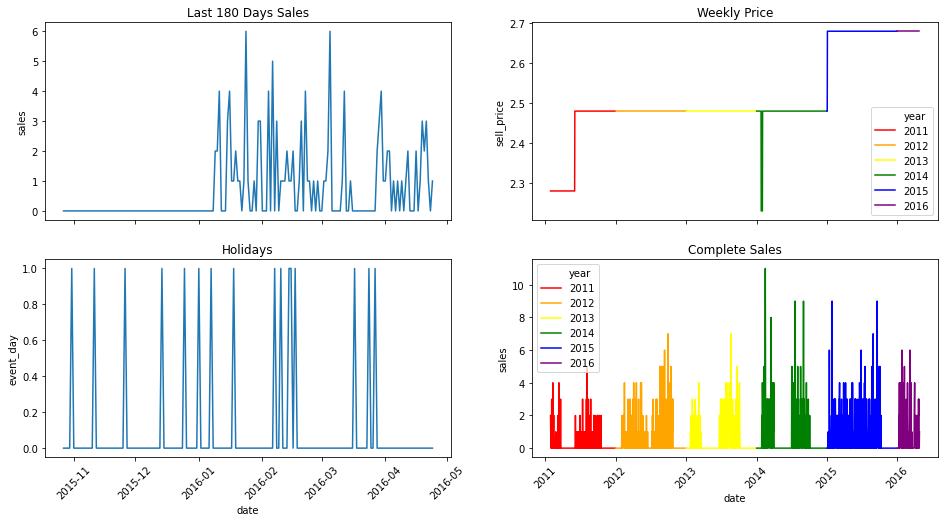

In [51]:
quad_plot(dataset = complete_data, id_filter = 'id', series_id = 'FOODS_1_011_CA_1_validation', days_prior = 180)